# Introduction

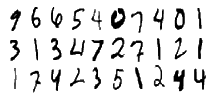

In [2]:
Image(filename='../image/front_page.png') 

In this project I will tackle the current Kaggle competition to classify images of handwritten digits.

After relying on sci-kit learn's library for so long I decided it would be a good idea to make my own functions for loading/splitting/outputting the data and to create a classifier from scratch. Doing this allowed me to understand how the algorithms underlying the machine learning models really work and gain an appreciation for vectorized operations and the time they save. 

https://www.kaggle.com/c/digit-recognizer

## Libraries

In [3]:
import numpy as np
import random
import time
from collections import Counter
from IPython.display import Image
import matplotlib.pyplot as plt

%matplotlib inline

## Loading the data

Data taken from https://www.kaggle.com/c/digit-recognizer

Note: I tried to use the full dataset but the computing the dot product of matrics with million of values was too much for my poor laptop. To accomodate this I cut down the original training data using linux commands from 42,000 rows to 1000:

```
$ wc -l train.csv
>>> 42001 train.csv

$ head -n 1000 train.csv > train_first1000.csv
```

In [4]:
def load_train_data(data_dir, train_file):
    """
    Loads the training file file into numpy arrays from given
    directory.
    
    Separates out the header, and the data from target.
    """
    # Read in train file.
    train_data = open(data_dir + train_file).read()
    
    # Split rows based on newline character.
    train_data = train_data.split("\n")
    
    # The first row is the header.
    header = train_data[0].split(',')
    
    # From row 1 to the end is the data.
    train_data = train_data[1:-1]
    
    # Inside each row, split values based on commas.
    train_data = [i.split(",") for i in train_data]
    
    # y is the first column, X is the rest of the columns.
    # Convert values from string to integers and store them in numpy arrays.
    y_train = np.array([int(i[0]) for i in train_data])
    X_train = np.array([[int(i[j]) for j in range(1,len(i))] for i in train_data])

    return header, X_train, y_train

In [5]:
# Directory and file details.
data_dir = "../data/"
train_file =  "train_first1000.csv" #"train.csv"

In [6]:
# Load in using function.
header, X_train, y_train = load_train_data(data_dir, train_file)

In [7]:
# Inspecting the header.
print header[0:5], header[-5:-1]

['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3'] ['pixel779', 'pixel780', 'pixel781', 'pixel782']


In [8]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0, 188, 255,  94,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 191, 250, 253,  93,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [9]:
X_train.shape

(999, 784)

The reduced data files contains 999 instances of digits. The first column "label" is the actual class of the hand-drawn digit, from zero through nine. The proceeding columns make-up the image. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

## Exploratory data analysis

C:\Users\Chris\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\transforms.py:1018: RuntimeWarning: invalid value encountered in not_equal
  if np.any(self._points != other.get_points()):
C:\Users\Chris\AppData\Local\Continuum\Anaconda\lib\site-packages\matplotlib\transforms.py:1563: RuntimeWarning: invalid value encountered in equal
  return np.all(self.get_matrix() == other.get_matrix())


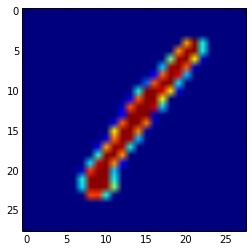

In [10]:
plt.imshow(X_train[0].reshape((28, 28)))

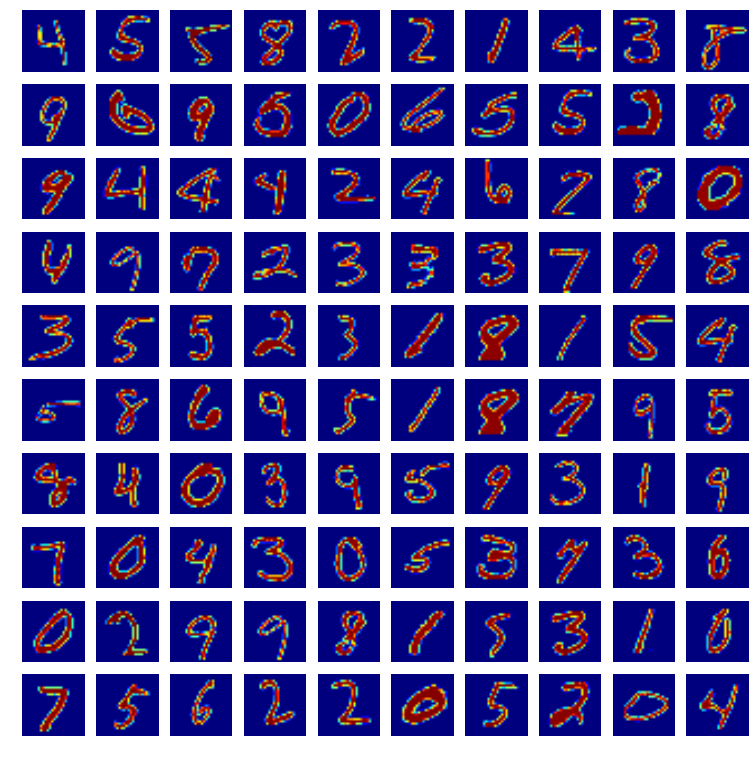

In [11]:
L = 10
plt.figure(figsize=(13,13))
for i in range(0, L*L):
    plt.subplot(L,L,i+1)
    plt.imshow(X_train[random.randint(0,699),:].reshape([28,28]))
    plt.axis('off')
        
plt.show()

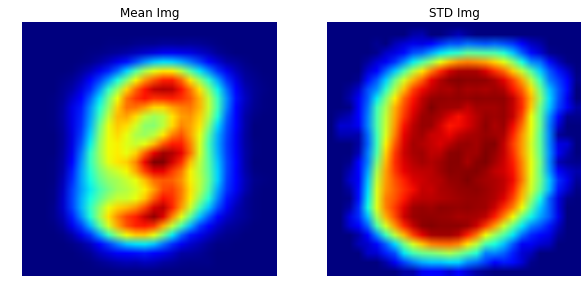

In [12]:
mean_img = np.mean(X_train, axis=0)
std_img = np.std(X_train, axis=0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(mean_img.reshape([28,28]))
plt.title('Mean Img')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(std_img.reshape([28,28]))
plt.title('STD Img')
plt.axis('off')
plt.show()

## Splitting the data

In [13]:
# Set random seed for reproducibility.
np.random.seed(0)

# Take a list of the indices and randomize the order.
indices = np.random.permutation(X_train.shape[0])

In [14]:
# Set the proportion of data saved for testing purposes.
test_proportion = 0.3

# Get the amount that corresponds to proportion
test_amount = int(X_train.shape[0] * test_proportion)
train_amount = X_train.shape[0] - test_amount

In [15]:
# Take the first 70% of indices as training, last 30% as testing.
training_idx, test_idx = indices[:train_amount], indices[test_amount:]

In [16]:
# Split the data and target into training and testing.
X_train, X_test, y_train, y_test = X_train[training_idx,:], X_train[test_idx,:], y_train[training_idx], y_train[test_idx]

## Defining KNN model

In [17]:
class KNearestNeighbor():
    """ 
    A kNN classifier with L2 euclidean distance. 
    """
    def __init__(self):
        pass

    def train(self, X, y):
        """
        Trains the classifier. For k-nearest neighbors this is just 
        memorizing the training data.
        
        Inputs:
        
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        # Remember the training data.
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        """
        Predict labels for test data using this classifier.
        
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.
        - num_loops: Determines which implementation to use to compute distances
          between training points and testing points.
          
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """

        # Compute the distance between each point
        dists = self.compute_distances(X)
        
        # Init array to hold label predictions.
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)

        for i in range(num_test):
            
            # Init array to hold k closest labels.
            k_closest_y = []
            
            # Sort dists and take corresponding labels.
            labels = self.y_train[np.argsort(dists[i,:])].flatten()
            
            # Find k nearest labels.
            k_closest_y = labels[:k]

            # Take most common label. In case of a tie take the smaller value.
            c = Counter(k_closest_y)
            y_pred[i] = c.most_common(1)[0][0]

        return y_pred
    
    def compute_distances(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using a nested loop over both the training data and the 
        test data.
        
        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        
        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        # Number of test and training points.
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        
        # Init empty array to hold distances.
        dists = np.zeros((num_test, num_train)) 

        # Dot product between points.
        dot_pro = np.dot(X, self.X_train.T)
        
        # Test and train matrices squared.
        sum_square_test = np.square(X).sum(axis = 1)
        sum_square_train = np.square(self.X_train).sum(axis = 1)
        
        # Vectorized Euclidean distance. (http://stackoverflow.com/posts/37903795/revisions)
        dists = np.sqrt(-2 * dot_pro + sum_square_train + np.matrix(sum_square_test).T)
        
        return dists

## Training the model

In [18]:
# Set number of nearest neighbours to take.
k = 5

# Initialize KNN classiier.
classifier = KNearestNeighbor()

# Train the model.
classifier.train(X_train, y_train)

## Evaluating the model

In [27]:
predictions = classifier.predict(X_test, k)

In [28]:
# Basic accuracy.
accuracy = (predictions == y_test).sum() / float(len(predictions)) * 100
print "{0:.2f}%".format(accuracy)

87.29%


C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in equal
  if __name__ == '__main__':


In [63]:
# Calculate the confusion matrix.
cm = np.zeros((10, 10))
for actual, predicted in zip(y_test, predictions):
    cm[actual][predicted] += 1

C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [62]:
cm

array([[ 74.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.],
       [  0.,  65.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
       [  2.,   4.,  70.,   1.,   1.,   0.,   0.,   4.,   2.,   0.],
       [  0.,   2.,   0.,  55.,   0.,   1.,   0.,   2.,   1.,   2.],
       [  0.,   0.,   0.,   0.,  60.,   0.,   1.,   1.,   0.,   9.],
       [  1.,   2.,   0.,   2.,   0.,  55.,   1.,   0.,   2.,   1.],
       [  1.,   1.,   0.,   0.,   2.,   1.,  63.,   0.,   0.,   0.],
       [  0.,   7.,   0.,   0.,   1.,   0.,   0.,  65.,   0.,   2.],
       [  1.,   4.,   0.,   3.,   3.,   3.,   0.,   0.,  44.,   2.],
       [  2.,   2.,   0.,   0.,   0.,   0.,   0.,   8.,   0.,  60.]])

The actual values are the rows and the predicted are the columns, both going from 0-9. For example the digit "2" is correctly predicted 70 times and only incorrectly predicted once as a "1". A visualization is needed to show where the model has trouble.

In [40]:
incorrect_idx = [predictions != y_test]

C:\Users\Chris\AppData\Roaming\Python\Python27\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in not_equal
  if __name__ == '__main__':


In [83]:
# Subset data, target, predictions on incorrect ones.
incorrect_data = X_test[incorrect_idx]
incorrect_label = predictions[incorrect_idx]
correct_label = y_test[incorrect_idx]

# Removing trailing 0.
incorrect_label = [int(i) for i in incorrect_label]

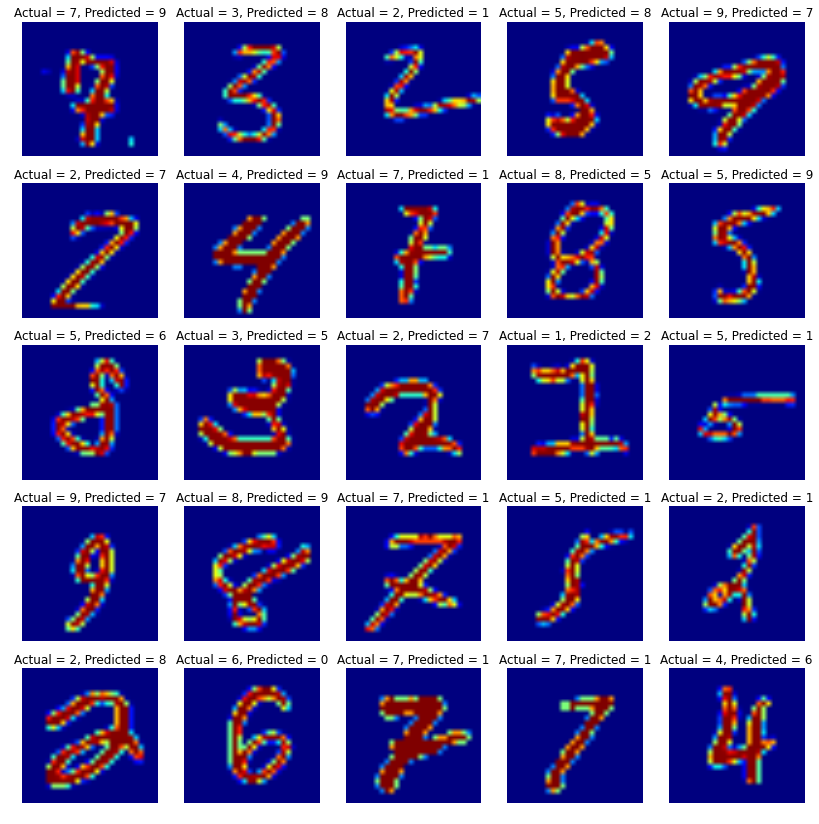

In [84]:
L = 5
plt.figure(figsize=(14, 14))
for i in range(0, L*L):
    plt.subplot(L, L, i+1)
    plt.imshow(incorrect_data[i,:].reshape([28,28]))
    plt.title("Actual = {}, Predicted = {}".format(correct_label[i], incorrect_label[i]))
    plt.axis('off')
        
plt.show()

In the first image in this plot it's easy to see how the model thought the "7" was a "9".

## Testing on Kaggle

In [21]:
def load_test_data(data_dir, train_file):
    """
    Loads the testing file into numpy arrays from given
    directory.
    """

    # Same as load_train_data .
    test_data = open(data_dir + test_file).read()
    test_data = test_data.split("\n")[1:-1]
    test_data = [i.split(",") for i in test_data]
    X_test = np.array([[int(i[j]) for j in range(0,len(i))] for i in test_data])

    return X_test

In [22]:
# Directory and file details.
test_file = "test.csv"

# Load in using function.
kaggle_test = load_test_data(data_dir, train_file)

In [23]:
predictions = classifier.predict(kaggle_test, k)

## Outputting the data

In [24]:
out_file = open("../data/predictions.csv", "w")
out_file.write("ImageId,Label\n")

for i in range(len(predictions)):
    out_file.write(str(i+1) + "," + str(int(predictions[i])) + "\n")
        
out_file.close()

## Conclusions

Using my own simple KNN classifier made from scratch, a basic test/train split and utliizing just 2% of the data, my model achieved an accuracy of 85.50% on Kaggle and a rank of 1158. More data would definitely improve the accuracy of the model by a lot as there may be some unorthodox handwriting in the training data. The model is currently running on 1,000 observations, roughly 100 per digit. Having a couple of bad data points here can easily mislead the model when picking the nearest neighbours.

## Recommendations

I want to implement the following things:

Compare and contrast using KNN with 2 loops, 1 loop, no loops.

Same as above with different distance metrics.

Implement cross validation to find optimum value of K.